# Step 1. Data Load

In [1]:
#@title 1.1. Mount google drive

'''

This Jupyter notebook files works in the Google Colab environment.
Otherwise, You may set a working directory with following commands :

%cd [working directory]

'''

from google.colab import drive

drive.mount('/content/drive')

%cd /content/drive/MyDrive/fMRI_summary/

Mounted at /content/drive
/content/drive/MyDrive/fMRI_summary


In [2]:
#@title 1.2. Load packages

'''
We load required packages and implemented codes.
There are five *.py files : visualize, util, model, train, loss.
If you want to modify the structure of the neural networks, you may have to revise model.py
If you want to modify the training process, you may have to revise either this jupyter notebook or train.py
'''


import os
import copy
import time
import torch
import random
import scipy.io

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm
from torch.utils.data import DataLoader

from visualize import loss_plot, binary_plot, ternary_plot, quaternary_plot
from util import MYTensorDataset, make_reproducibility, make_masking, make_arbitrary_masking, k_fold_index, make_decision, make_binary_decision, binary_accuracy, multiclass_accuracy, contingency_table
from model import Attention, age_estimator, binary_hybrid, multi_hybrid
from train import normal_age_pretrain, patient_age_pretrain, coupled_train
from loss import Binary_module, NLL_module, Proposed_module, loss_generator



In [3]:
#@title 1.2. Read data from mat/xlsx file

'''
Step 1 : Load data from *.mat files


ADNI_CN     : numpy array [ 32 x 116 x 5937] Healthy / Normal                    / Old
ADNI_MCI_NC : numpy array [ 26 x 116 x 5937] Disease / Mild Cognitive Impairment / Non-converter
ADNI_MCI_C  : numpy array [ 22 x 116 x 5937] Disease / Mild Cognitive Impairment / Converter
ADNI_AD     : numpy array [ 32 x 116 x 5937] Disease / Alzheimer's Disease
SNU_CN      : numpy array [ 38 x  93 x 5937] Healthy / Normal                    / Young to old

ADNI_data   : numpy array [112 x 116 x 5937]

age_mmse    : numpy array [150 x   2]        1st row : age, 2nd row : mmse score
'''

ADNI_CN_list = ['002_S_0295', '002_S_0413', '002_S_0685', '002_S_1261', '002_S_1280',
                '002_S_4213', '002_S_4225', '002_S_4264', '002_S_4270', '006_S_4150',
                '006_S_4357', '006_S_4449', '006_S_4485', '010_S_4442', '012_S_4026',
                '012_S_4643', '013_S_4579', '013_S_4580', '013_S_4616', '018_S_4257',
                '018_S_4313', '018_S_4349', '018_S_4399', '018_S_4400', '019_S_4367',
                '031_S_4032', '031_S_4218', '031_S_4474', '031_S_4496', '053_S_4578',
                '136_S_4269', '136_S_4433']

ADNI_MCI_NC_list = ['002_S_2073', '002_S_4229', '002_S_4237', '002_S_4447', '002_S_4473',
                    '002_S_4654', '012_S_4128', '013_S_2389', '013_S_4395', '013_S_4917',
                    '018_S_4868', '019_S_4285', '019_S_4548', '031_S_2018', '031_S_2022',
                    '031_S_2233', '031_S_4029', '031_S_4590', '053_S_0919', '053_S_2357',
                    '053_S_4557', '053_S_4813', '130_S_4405', '130_S_4417', '130_S_4468',
                    '130_S_4817']

ADNI_MCI_C_list = ['002_S_4171', '002_S_4521', '006_S_4346', '006_S_4363', '006_S_4515',
                   '012_S_4094', '012_S_4188', '013_S_1186', '013_S_4595', '019_S_4293',
                   '019_S_4680', '031_S_4005', '031_S_4042', '031_S_4149', '031_S_4721',
                   '130_S_2373', '130_S_2391', '130_S_2403', '130_S_4250', '130_S_4294',
                   '130_S_4415', '130_S_4542']

ADNI_AD_list = ['002_S_5018', '006_S_4153', '006_S_4192', '006_S_4546', '006_S_4867',
                '013_S_5071', '018_S_4696', '018_S_4733', '018_S_5240', '019_S_4252',
                '019_S_4477', '019_S_4549', '019_S_5012', '019_S_5019', '031_S_4024',
                '053_S_5070', '053_S_5208', '100_S_5106', '130_S_4589', '130_S_4641',
                '130_S_4660', '130_S_4730', '130_S_4971', '130_S_4982', '130_S_4984',
                '130_S_4990', '130_S_4997', '130_S_5006', '130_S_5059', '130_S_5231',
                '131_S_5138', '136_S_4993']

SNU_CN_list = ['06', '07', '08', '09', '10',
               '11', '12', '13', '14', '15',
               '16', '18', '19', '20', '21',
               '22', '23', '25', '26', '27',
               '28', '29', '30', '31', '33',
               '35', '36', '38', '39', '40',
               '41', '43', '44', '45', '46',
               '48', '49', '51']


ADNI_CN_full = [scipy.io.loadmat(f'Kcore_pos/ADNI_CN/coreness_{i}.mat') for i in ADNI_CN_list]
ADNI_CN_data = [data['coreness_all'] for data in ADNI_CN_full]
ADNI_CN = np.concatenate([np.reshape(np.float32(data.T), [1, -1, 5937]) for data in ADNI_CN_data])

ADNI_MCI_NC_full = [scipy.io.loadmat(f'Kcore_pos/ADNI_MCI_NC/coreness_{i}.mat') for i in ADNI_MCI_NC_list]
ADNI_MCI_NC_data = [data['coreness_all'] for data in ADNI_MCI_NC_full]
ADNI_MCI_NC = np.concatenate([np.reshape(np.float32(data.T), [1, -1, 5937]) for data in ADNI_MCI_NC_data])

ADNI_MCI_C_full = [scipy.io.loadmat(f'Kcore_pos/ADNI_MCI_C/coreness_{i}.mat') for i in ADNI_MCI_C_list]
ADNI_MCI_C_data = [data['coreness_all'] for data in ADNI_MCI_C_full]
ADNI_MCI_C = np.concatenate([np.reshape(np.float32(data.T), [1, -1, 5937]) for data in ADNI_MCI_C_data])

ADNI_AD_full = [scipy.io.loadmat(f'Kcore_pos/ADNI_AD/coreness_{i}.mat') for i in ADNI_AD_list]
ADNI_AD_data = [data['coreness_all'] for data in ADNI_AD_full]
ADNI_AD = np.concatenate([np.reshape(np.float32(data.T), [1, -1, 5937]) for data in ADNI_AD_data])

SNU_CN_full = [scipy.io.loadmat(f'Kcore_pos/SNU_CN/coreness_normPM{i}.mat') for i in SNU_CN_list]
SNU_CN_data = [data['coreness_all'] for data in SNU_CN_full]
SNU_CN = np.concatenate([np.reshape(np.float32(data.T), [1, -1, 5937]) for data in SNU_CN_data])

age_mmse = np.array(pd.read_excel('Kcore_pos/Age_MMSE.xlsx')[['Age', 'MMSE']])

# concatenate dataset

ADNI_data = np.concatenate([ADNI_CN, ADNI_MCI_NC, ADNI_MCI_C, ADNI_AD])

normal_N = 70
normal_val_N = 20
patient_N = 80
N = 150

## 1.3. Define subject-level data

In [4]:
#@title 1.3.1. Define subject-level numpy array data

'''
Step 2 : Define subject-level numpy array
Since the maximum value in ADNI_data and SNU_CN is 612, we scale the data by multiplying 0.001.

subject_data    : numpy array [150 x  93 x 5937]
subject_age     : numpy array [150,]
subject_mmse    : numpy array [150,]

normal_data     : numpy array [ 70 x  93 x 5937]
normal_age      : numpy array [ 70,]
normal_mmse     : numpy array [ 70,]

patient_data    : numpy array [ 80 x  93 x 5937]
patient_age     : numpy array [ 80,]
patient_mmse    : numpy array [ 80,]
'''

subject_data = np.concatenate([ADNI_data[:,0:93,:], SNU_CN]) * 0.001

subject_age = age_mmse[:,0]
subject_mmse = age_mmse[:,1]

normal_data = np.concatenate([ADNI_data[0:32, 0:93, :], SNU_CN]) * 0.001
normal_age  = np.concatenate([subject_age[0:32],  subject_age[112:150] ])
normal_mmse = np.concatenate([subject_mmse[0:32], subject_mmse[112:150]])

patient_data = subject_data[32:112]
patient_age = subject_age[32:112]
patient_mmse = subject_mmse[32:112]

In [5]:
#@title 1.3.2. Convert to torch tensor

'''
Step 4. Convert to torch tensor

subject_data_torch    : torch tensor [150 x  93 x 5937]
subject_age_torch     : torch tensor [150,]
subject_mmse_torch    : torch tensor [150,]

normal_data_torch     : torch tensor [70 x   93 x 5937]
normal_age_torch      : torch tensor [70]
nromal_mmse_torch     : torch tensor [70]

patient_data_torch    : torch tensor [80 x   93 x 5937]
patient_age_torch     : torch tensor [80]
patient_mmse_torch    : torch tensor [80]
'''

subject_data_torch = torch.tensor(subject_data).float()
subject_age_torch = torch.tensor(subject_age).float()
subject_mmse_torch = torch.tensor(subject_mmse).float()

normal_data_torch = torch.tensor(normal_data).float()
normal_age_torch  = torch.tensor(normal_age).float()
normal_mmse_torch = torch.tensor(normal_mmse).float()

patient_data_torch = torch.tensor(patient_data).float()
patient_age_torch = torch.tensor(patient_age).float()
patient_mmse_torch = torch.tensor(patient_mmse).float()


# Step 2. Normal age prediction

In [6]:
#@title 2.1. Define torch dataset

'''
We define a torch dataset for age prediction

subj_normal_age_dataset  : torch dataset for normal group
subj_patient_age_dataset : torch dataset for patient group
'''

subj_normal_age_dataset = MYTensorDataset(normal_data_torch, normal_age_torch, normal_mmse_torch)
subj_patient_age_dataset = MYTensorDataset(patient_data_torch, patient_age_torch, patient_mmse_torch)

In [7]:
#@title 2.2. Experiment setup

'''
Here we define hyperparameters for normal age prediction step.
These are optimal hyperparameters for current setup.

Since the classification results depend no random seed,
we repeat experiments for 5 times (=: repitition)

Hyperparameters for neural networks :
 - hidden dimension : 64
 - number of hidden layers in LSTM : 2

Hyperparamters for Adam optimizer :
 - learning rate : 1e-3
 - weight decay  : 1e-2
 - batch size : 8

Hyperparameters for early stopping :
 - patience : 5
 - maximal number of epochs : 300

'''

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
repetition = 5      # how many times we repeat
patience = 30
subj_normal_N = normal_N

# optimal hyperparameter
learning_rate = 1e-3
weight_decay = 1e-2
num_epoch = 300
subj_normal_batch_size = 8
h_dim = 64
num_layers = 2

make_reproducibility(1)

In [8]:
#@title 2.3. K-fold CV setup

'''
To obtain predictions for a normal group, we adapt 10-fold CV.
That is, in each fold, we predict 7 data based on other 63 training data,
Note that to employ an early stopping, we again divide the training data by 56 and 7 (validation).

'''

num_fold = 10
seed_list = [10 + i for i in range(repetition)]

subj_normal_indice_list = [k_fold_index(N = normal_N, k = num_fold, SEED = seed) for seed in seed_list]
subj_indice_list = [k_fold_index(N = N, k = num_fold, SEED = (10+i)) for i in range(repetition)]

1th fold starting.


  0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
 20%|██        | 60/300 [00:05<00:22, 10.83it/s]


0th fold stopped training at 59th epoch
2th fold starting.


 26%|██▋       | 79/300 [00:06<00:17, 12.96it/s]


1th fold stopped training at 78th epoch
3th fold starting.


 32%|███▏      | 95/300 [00:07<00:15, 13.54it/s]


2th fold stopped training at 94th epoch
4th fold starting.


 19%|█▊        | 56/300 [00:04<00:18, 13.32it/s]


3th fold stopped training at 55th epoch
5th fold starting.


 22%|██▏       | 67/300 [00:04<00:17, 13.50it/s]


4th fold stopped training at 66th epoch
6th fold starting.


 26%|██▋       | 79/300 [00:06<00:16, 13.11it/s]


5th fold stopped training at 78th epoch
7th fold starting.


 39%|███▉      | 118/300 [00:09<00:13, 13.05it/s]


6th fold stopped training at 117th epoch
8th fold starting.


 21%|██▏       | 64/300 [00:04<00:18, 12.83it/s]


7th fold stopped training at 63th epoch
9th fold starting.


 44%|████▍     | 132/300 [00:10<00:12, 13.19it/s]


8th fold stopped training at 131th epoch
10th fold starting.


 36%|███▋      | 109/300 [00:08<00:14, 13.47it/s]


9th fold stopped training at 108th epoch


/content/drive/MyDrive/fMRI_summary/visualize.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_loss = np.asarray(result[1]).mean(axis = 0)
/content/drive/MyDrive/fMRI_summary/visualize.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_loss = np.asarray(result[2]).mean(axis = 0)


1th fold starting.


 41%|████      | 123/300 [00:09<00:13, 13.18it/s]


0th fold stopped training at 122th epoch
2th fold starting.


 26%|██▋       | 79/300 [00:05<00:16, 13.18it/s]


1th fold stopped training at 78th epoch
3th fold starting.


 22%|██▏       | 66/300 [00:05<00:18, 12.92it/s]


2th fold stopped training at 65th epoch
4th fold starting.


 20%|██        | 60/300 [00:04<00:17, 13.53it/s]


3th fold stopped training at 59th epoch
5th fold starting.


 30%|██▉       | 89/300 [00:06<00:15, 13.23it/s]


4th fold stopped training at 88th epoch
6th fold starting.


 23%|██▎       | 69/300 [00:05<00:17, 13.00it/s]


5th fold stopped training at 68th epoch
7th fold starting.


 32%|███▏      | 97/300 [00:07<00:15, 13.25it/s]


6th fold stopped training at 96th epoch
8th fold starting.


 58%|█████▊    | 174/300 [00:13<00:09, 13.15it/s]


7th fold stopped training at 173th epoch
9th fold starting.


 25%|██▍       | 74/300 [00:05<00:17, 13.11it/s]


8th fold stopped training at 73th epoch
10th fold starting.


 29%|██▊       | 86/300 [00:06<00:17, 12.44it/s]


9th fold stopped training at 85th epoch
1th fold starting.


 23%|██▎       | 70/300 [00:05<00:17, 13.41it/s]


0th fold stopped training at 69th epoch
2th fold starting.


 25%|██▌       | 76/300 [00:05<00:16, 13.18it/s]


1th fold stopped training at 75th epoch
3th fold starting.


 36%|███▌      | 107/300 [00:07<00:14, 13.43it/s]


2th fold stopped training at 106th epoch
4th fold starting.


 37%|███▋      | 110/300 [00:08<00:13, 13.61it/s]


3th fold stopped training at 109th epoch
5th fold starting.


 22%|██▏       | 66/300 [00:04<00:17, 13.42it/s]


4th fold stopped training at 65th epoch
6th fold starting.


 31%|███       | 93/300 [00:06<00:15, 13.71it/s]


5th fold stopped training at 92th epoch
7th fold starting.


 18%|█▊        | 54/300 [00:04<00:18, 13.29it/s]


6th fold stopped training at 53th epoch
8th fold starting.


 38%|███▊      | 114/300 [00:08<00:13, 13.48it/s]


7th fold stopped training at 113th epoch
9th fold starting.


 21%|██        | 63/300 [00:04<00:17, 13.26it/s]


8th fold stopped training at 62th epoch
10th fold starting.


 33%|███▎      | 100/300 [00:07<00:14, 13.71it/s]


9th fold stopped training at 99th epoch
1th fold starting.


 38%|███▊      | 114/300 [00:08<00:13, 13.58it/s]


0th fold stopped training at 113th epoch
2th fold starting.


 29%|██▉       | 87/300 [00:06<00:15, 13.38it/s]


1th fold stopped training at 86th epoch
3th fold starting.


 20%|██        | 60/300 [00:04<00:17, 13.54it/s]


2th fold stopped training at 59th epoch
4th fold starting.


 27%|██▋       | 81/300 [00:05<00:16, 13.54it/s]


3th fold stopped training at 80th epoch
5th fold starting.


 21%|██        | 62/300 [00:04<00:17, 13.47it/s]


4th fold stopped training at 61th epoch
6th fold starting.


 18%|█▊        | 53/300 [00:03<00:18, 13.70it/s]


5th fold stopped training at 52th epoch
7th fold starting.


 27%|██▋       | 80/300 [00:05<00:16, 13.47it/s]


6th fold stopped training at 79th epoch
8th fold starting.


 17%|█▋        | 50/300 [00:03<00:18, 13.55it/s]


7th fold stopped training at 49th epoch
9th fold starting.


 30%|███       | 90/300 [00:06<00:15, 13.50it/s]


8th fold stopped training at 89th epoch
10th fold starting.


 23%|██▎       | 70/300 [00:05<00:16, 13.64it/s]


9th fold stopped training at 69th epoch
1th fold starting.


 34%|███▍      | 103/300 [00:07<00:14, 13.34it/s]


0th fold stopped training at 102th epoch
2th fold starting.


 19%|█▉        | 58/300 [00:04<00:17, 13.70it/s]


1th fold stopped training at 57th epoch
3th fold starting.


 32%|███▏      | 97/300 [00:07<00:14, 13.56it/s]


2th fold stopped training at 96th epoch
4th fold starting.


 28%|██▊       | 84/300 [00:06<00:15, 13.69it/s]


3th fold stopped training at 83th epoch
5th fold starting.


 18%|█▊        | 53/300 [00:03<00:18, 13.59it/s]


4th fold stopped training at 52th epoch
6th fold starting.


 56%|█████▌    | 167/300 [00:12<00:09, 13.58it/s]


5th fold stopped training at 166th epoch
7th fold starting.


 22%|██▏       | 66/300 [00:04<00:17, 13.51it/s]


6th fold stopped training at 65th epoch
8th fold starting.


 33%|███▎      | 99/300 [00:07<00:14, 13.68it/s]


7th fold stopped training at 98th epoch
9th fold starting.


 18%|█▊        | 54/300 [00:03<00:17, 13.80it/s]


8th fold stopped training at 53th epoch
10th fold starting.


 22%|██▏       | 65/300 [00:04<00:17, 13.74it/s]


9th fold stopped training at 64th epoch


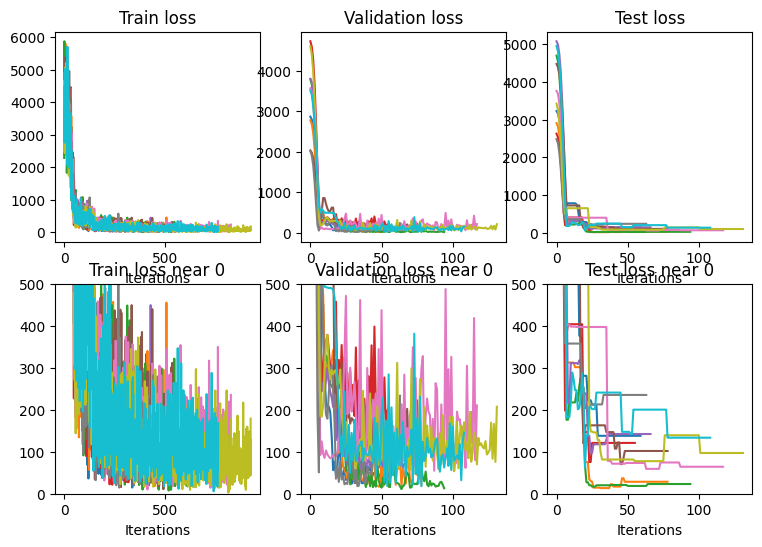

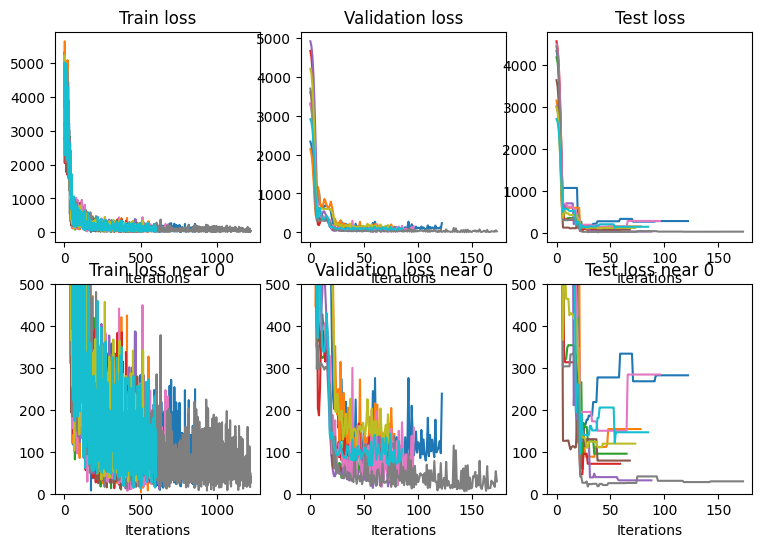

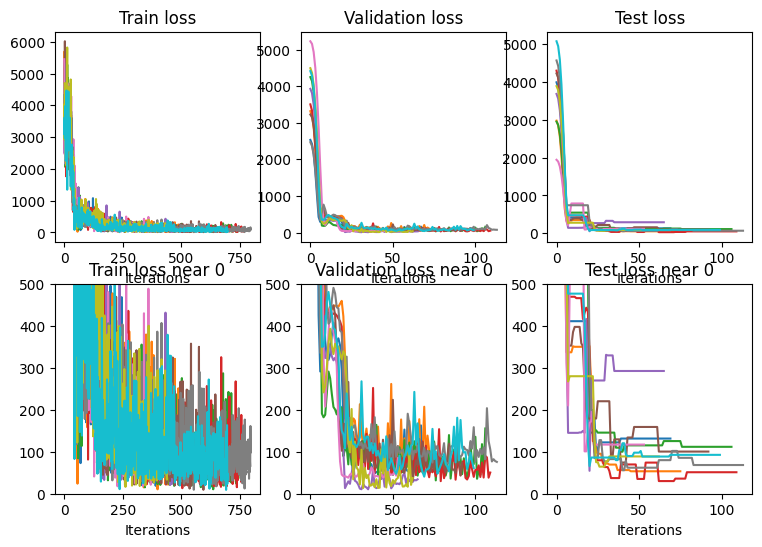

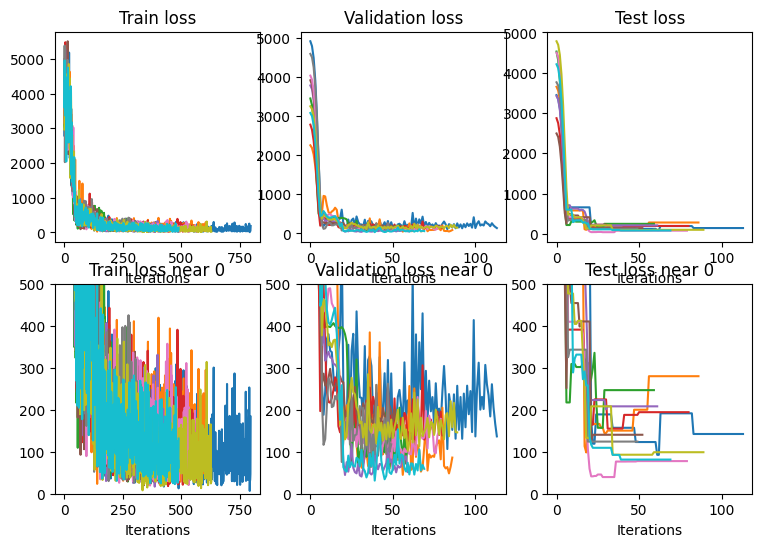

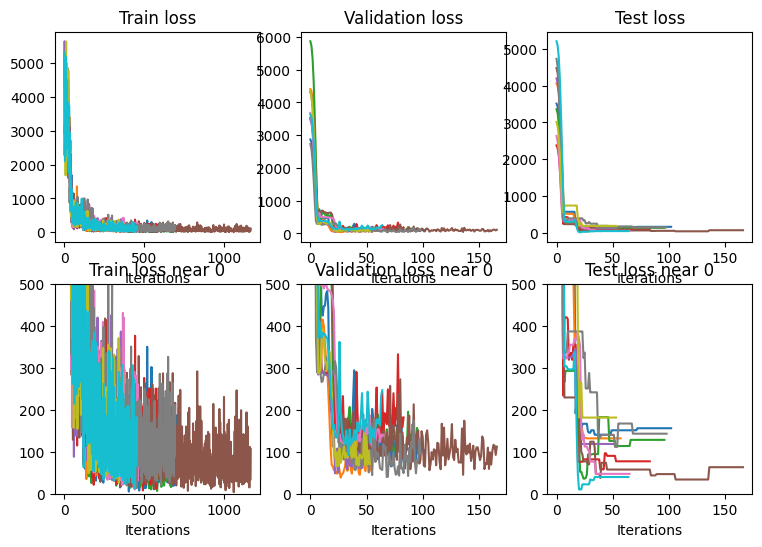

In [9]:
#@title 2.4 Load/train data

# Write folder name
title = "normal_age_prediction"

'''
2.4.1. Load data if exist
If there already exist saved data, we can load them.
In that case, run the below annotated code :
'''

# normal_pred_list = torch.tensor(np.array(pd.read_csv(f'{title}/pred.csv', header = None))).float()

'''
2.4.2. Train data
If there does not exists saved data, we train the data.
If we use V100 GPU in Google colab, it takes about 9 minutes. (110 seconds per one 1 repitition)
'''

# random seed
seed_list = [100 * (i+1) for i in range(repetition)]

os.makedirs(title, exist_ok=True)
normal_pred_list = []
normal_train_loss_list_list = []
normal_test_loss_list_list = []

for m in range(repetition) :
    result = normal_age_pretrain(
        subj_normal_age_dataset, DEVICE, subj_normal_indice_list[m], SEED = seed_list[m], N = normal_N,
        h_dim = h_dim, num_layers = num_layers, num_epoch = num_epoch, batch_size = subj_normal_batch_size,
        loss_type = "MSE", learning_rate = learning_rate, weight_decay = weight_decay, patience = patience
    )
    normal_pred_list.append(result[0])
    normal_train_loss_list_list.append(result[1])
    normal_test_loss_list_list.append(result[2])
    loss_plot(result, num_fold, h_dim, num_layers, num_epoch, learning_rate, seed_list[m], title = title)

np.savetxt(f'{title}/pred.csv', torch.concat(normal_pred_list).reshape(-1, normal_N).numpy(), delimiter = ",")

# Step 3. Patient age prediction

Next, based on normal group data, we predict ages for patient group.
Because we have to use the same model, we do not change the hyperparameters at all.



In [10]:
#@title 3.1. Define torch dataset for patient detection process

'''
To employ an early stopping again, we divide the normal group by 63 training set and 7 validation set.
Based on training (normal) dataset and validation (normal) dataset, we train the age prediction neural networks model for each repitition.
With the trained model, we predict ages for the patient group for each repitition.
'''

subj_normal_N = normal_N
subj_val_N = normal_val_N
subj_patient_N = patient_N

train_val_ind_list = [make_arbitrary_masking(normal_N, range(20), randomize = True, SEED = 20 + i) for i in range(repetition)]

subj_normal_train_dataset_list = [torch.utils.data.Subset(subj_normal_age_dataset, indices = ind_list[0]) for ind_list in train_val_ind_list]
subj_normal_val_dataset_list = [torch.utils.data.Subset(subj_normal_age_dataset, indices = ind_list[1]) for ind_list in train_val_ind_list]

 24%|██▎       | 71/300 [00:10<00:34,  6.54it/s]


Patient age prediction stopped training at 70th epoch


 26%|██▌       | 77/300 [00:11<00:33,  6.56it/s]


Patient age prediction stopped training at 76th epoch


 41%|████      | 122/300 [00:18<00:26,  6.64it/s]


Patient age prediction stopped training at 121th epoch


 24%|██▍       | 72/300 [00:11<00:35,  6.47it/s]


Patient age prediction stopped training at 71th epoch


 31%|███▏      | 94/300 [00:14<00:31,  6.54it/s]


Patient age prediction stopped training at 93th epoch


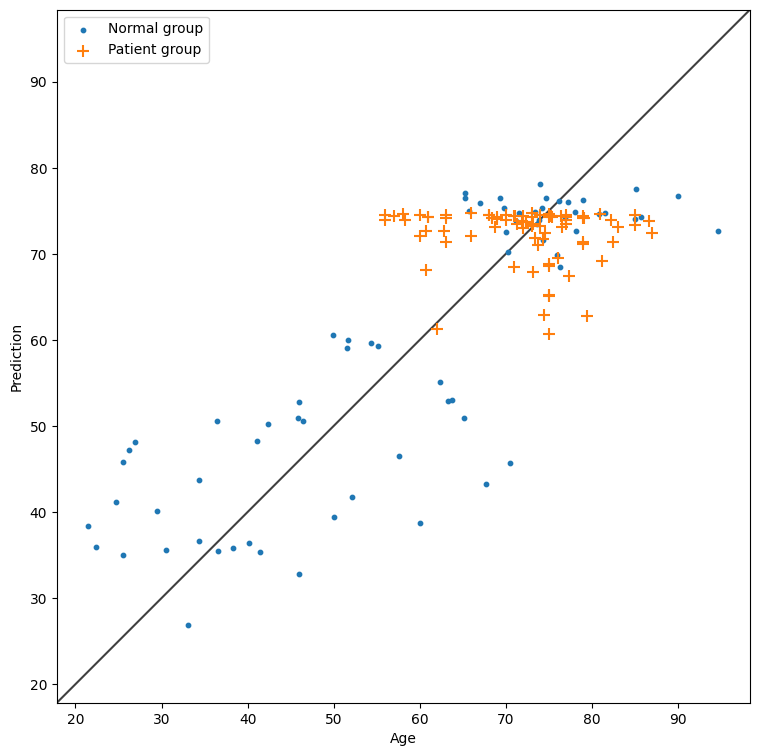

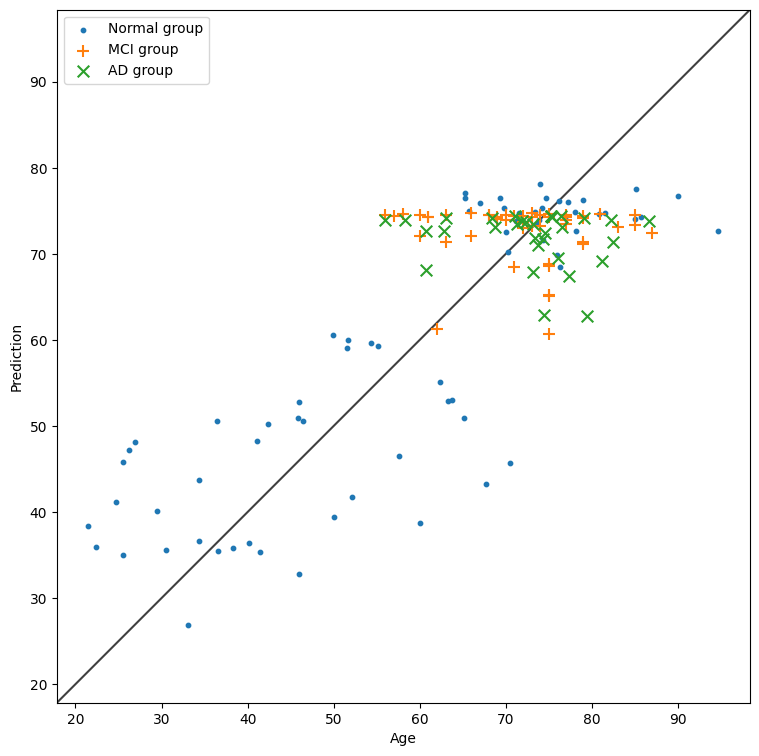

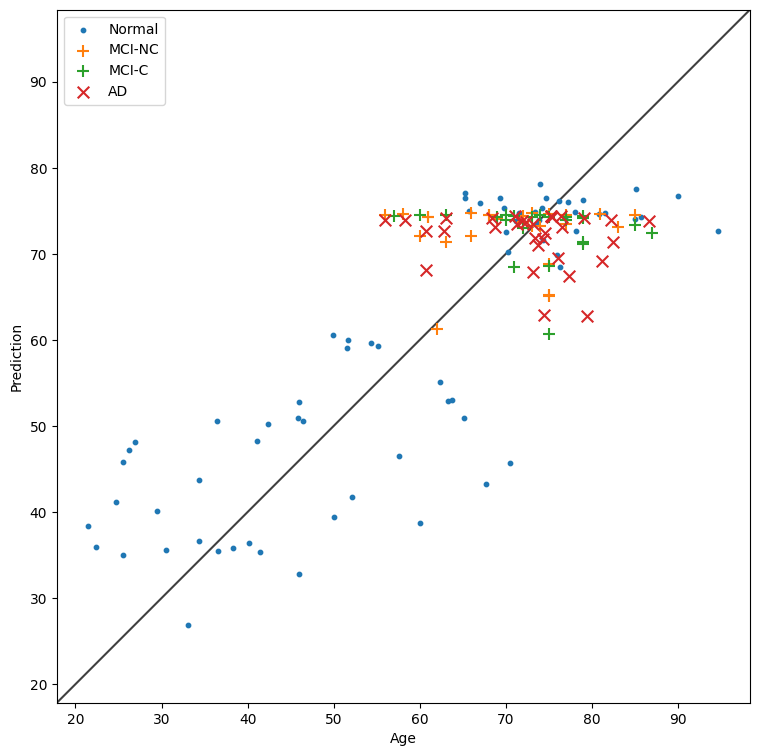

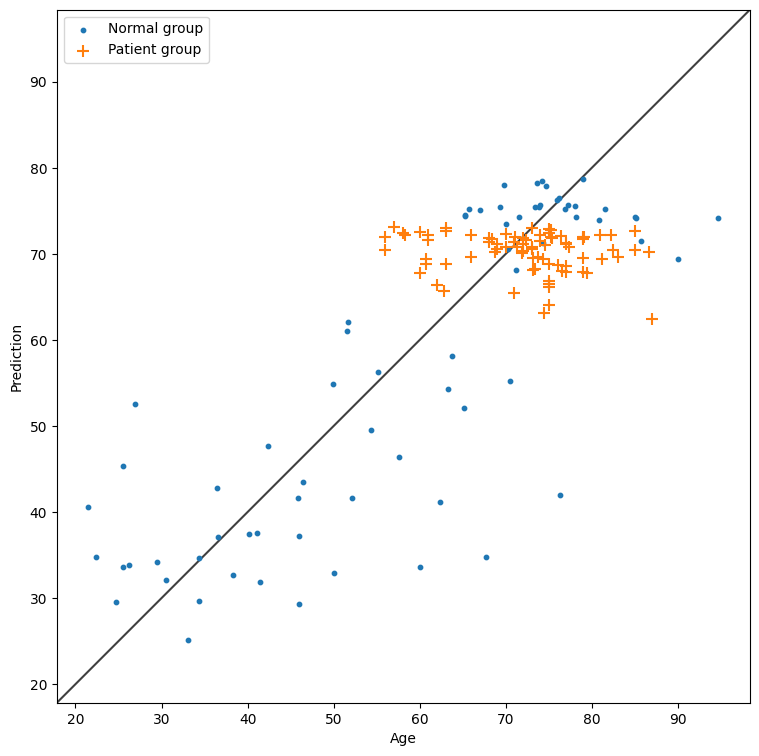

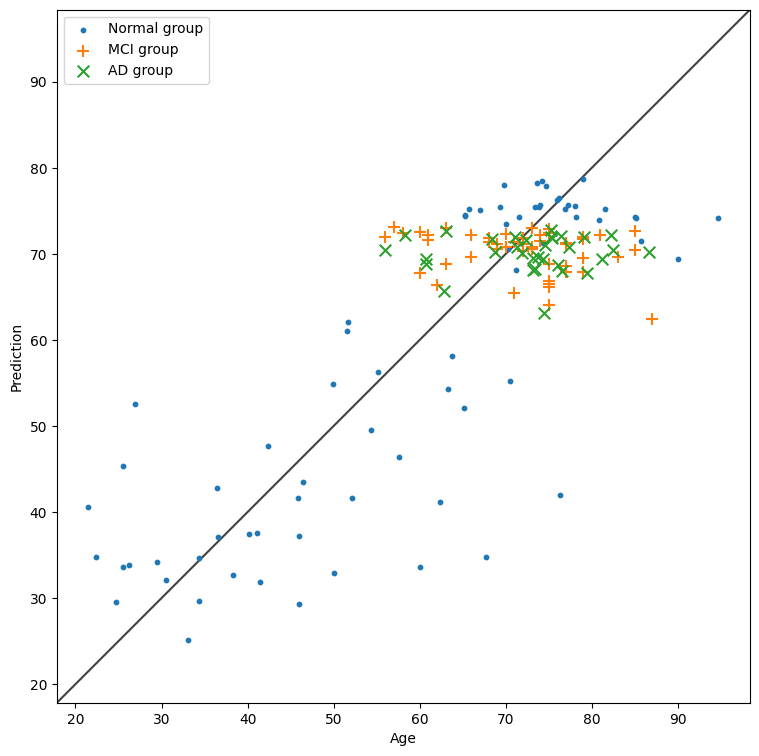

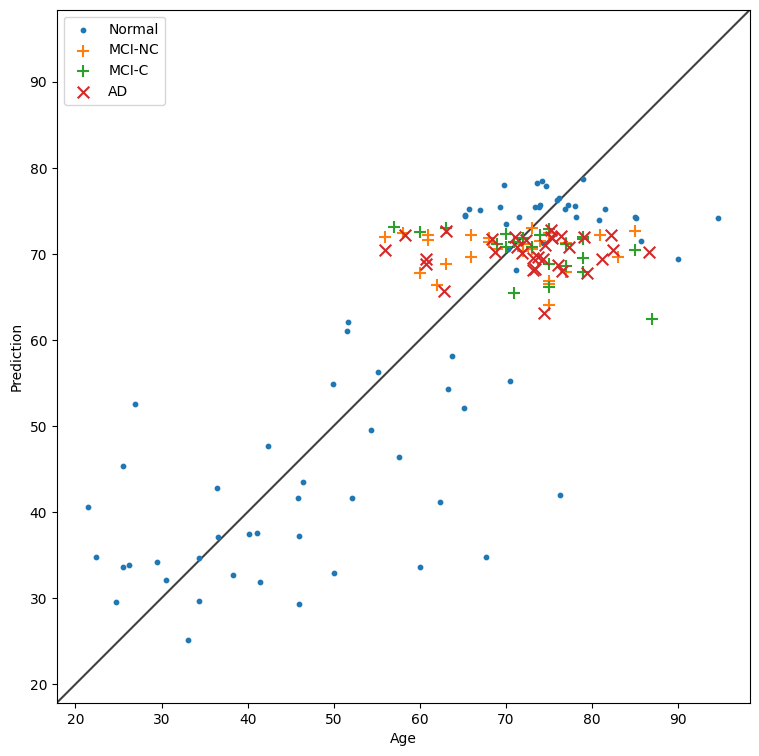

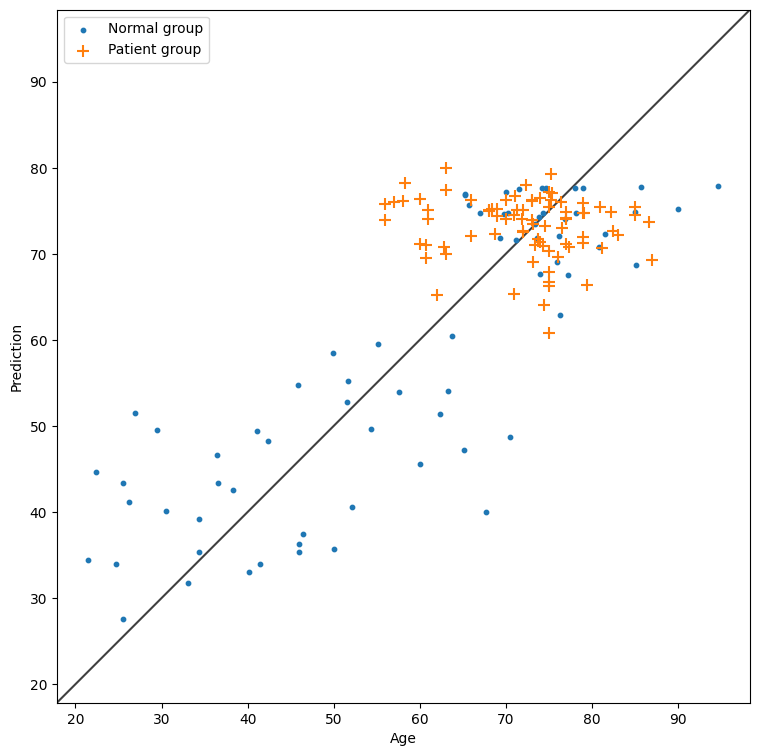

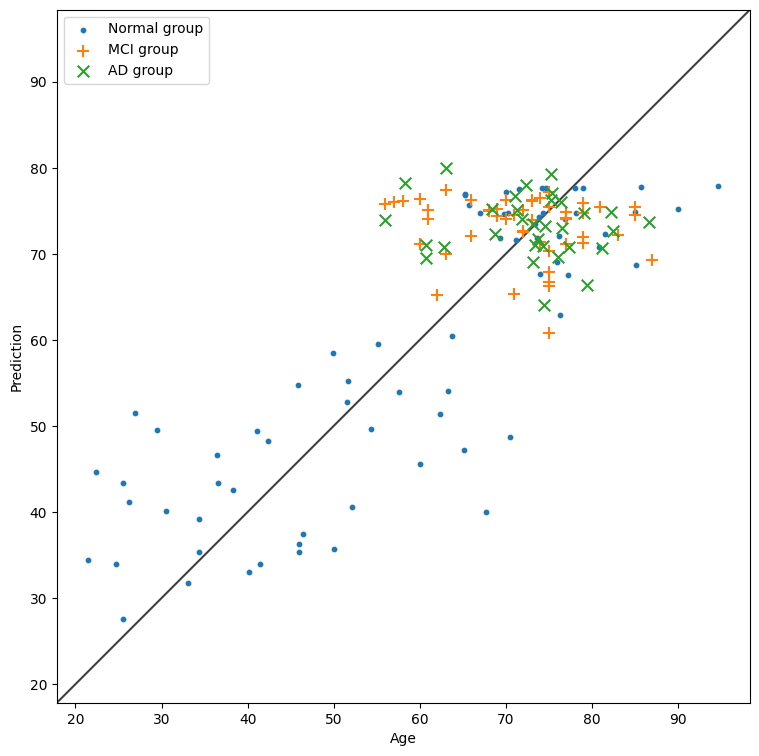

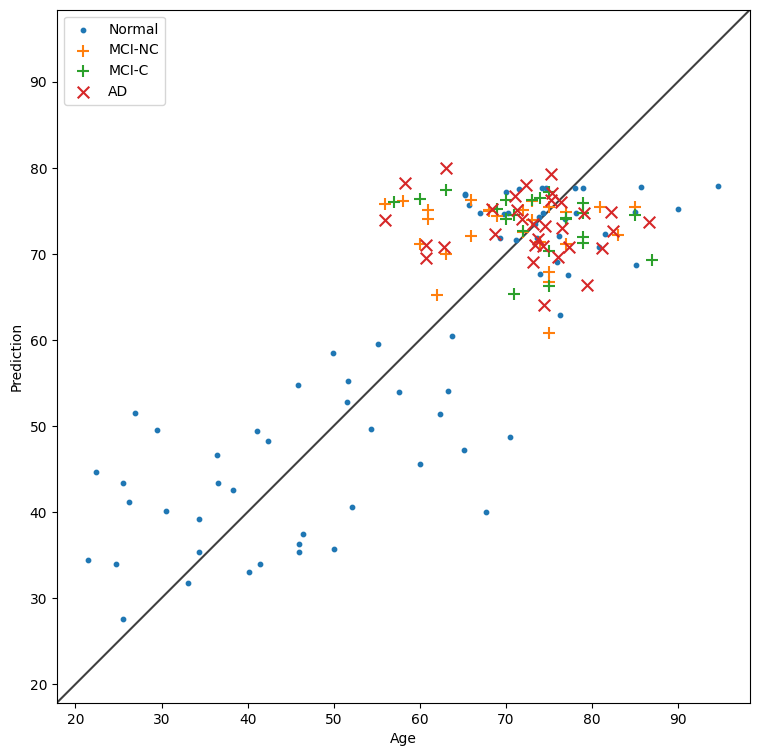

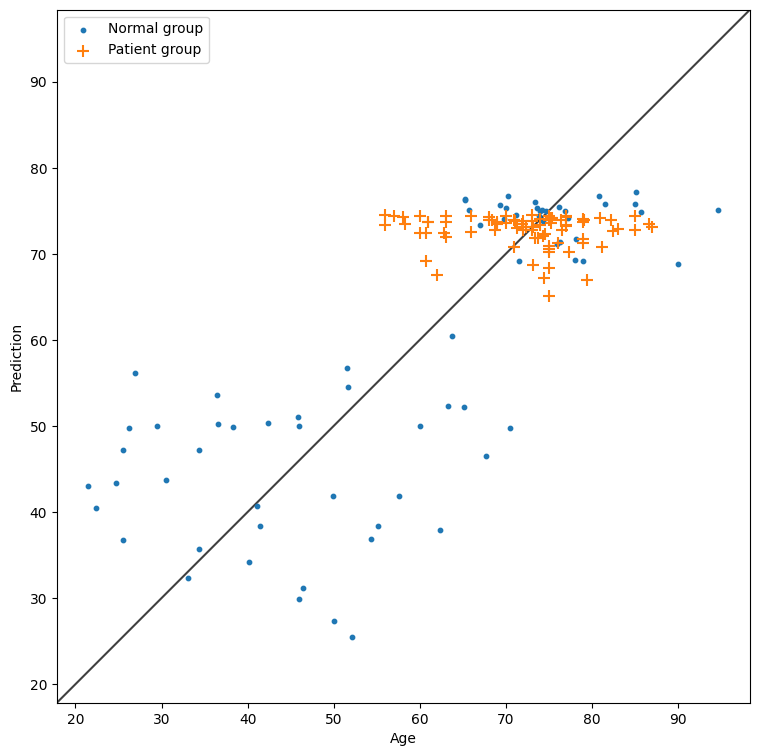

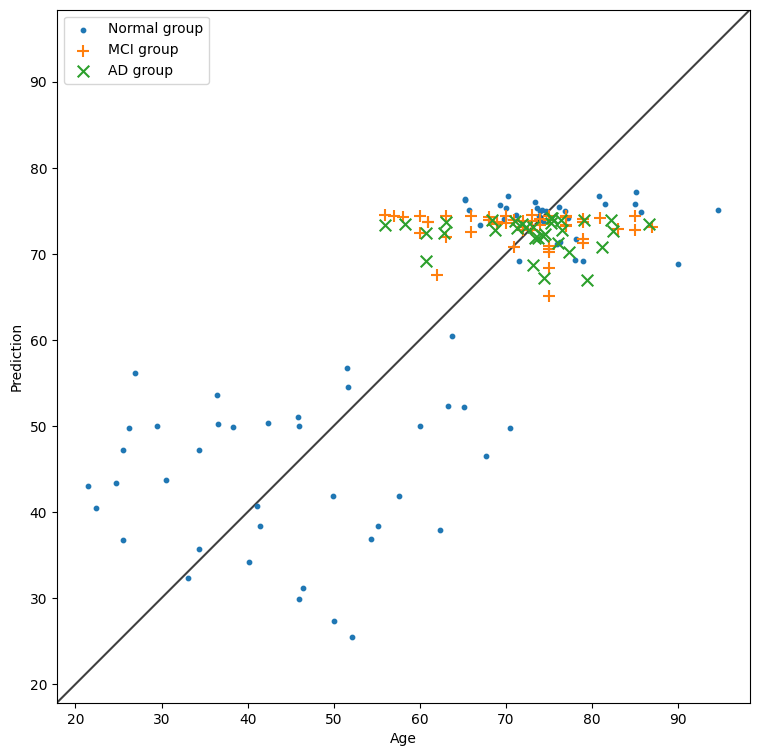

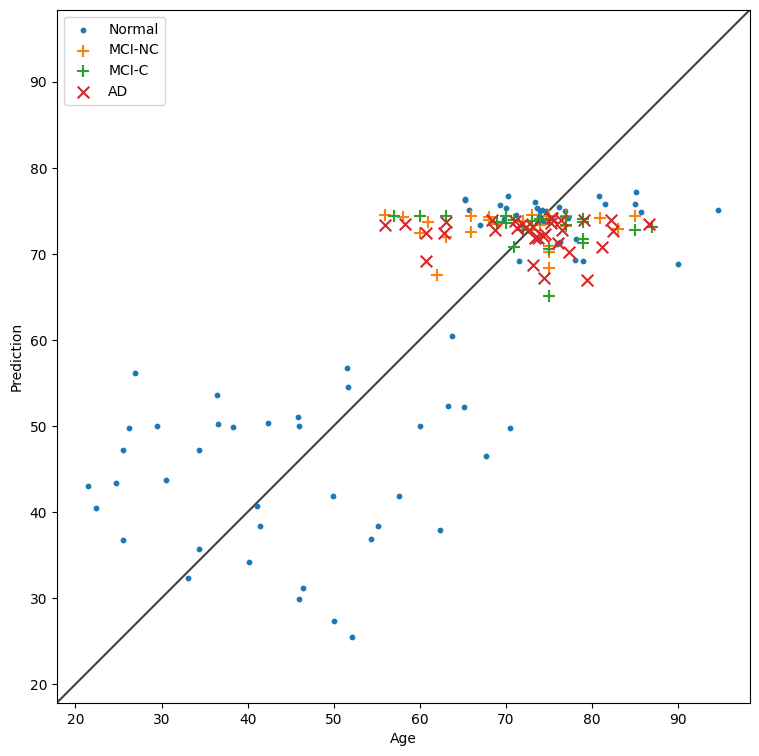

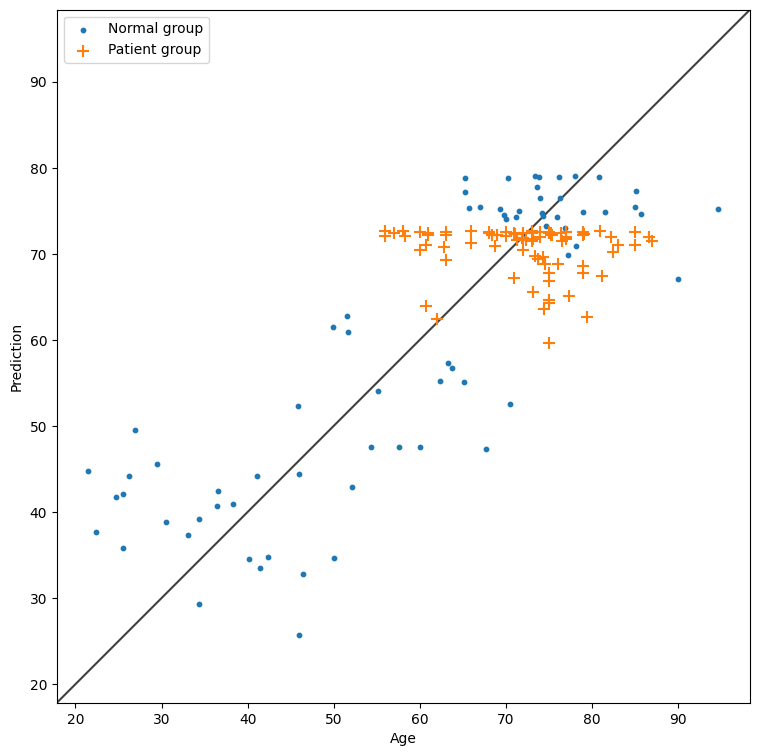

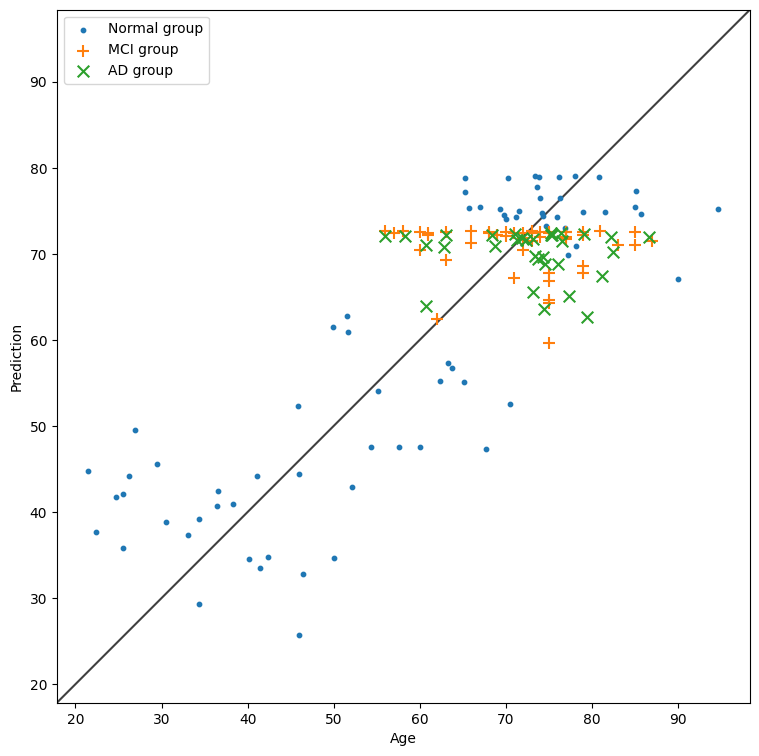

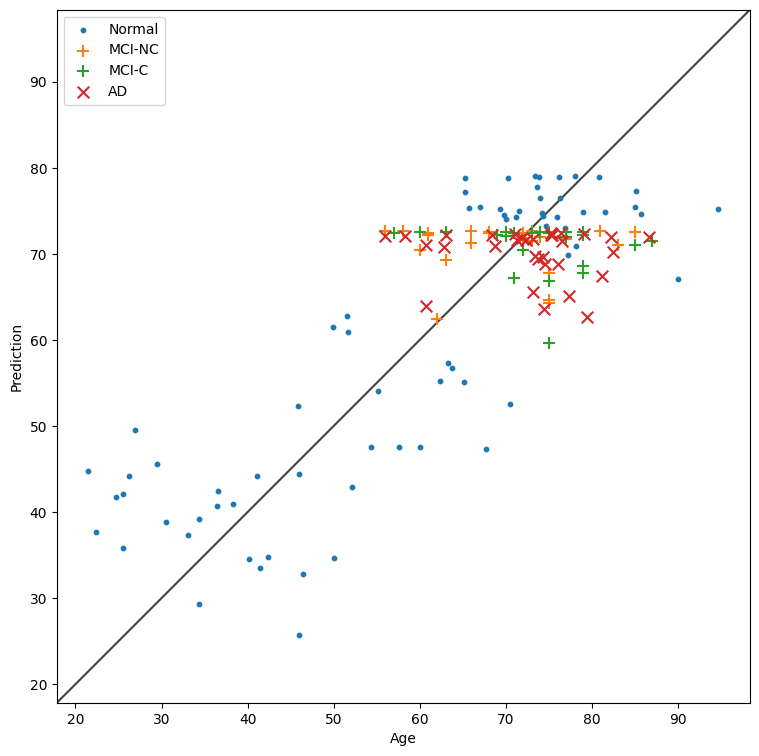

In [11]:
#@title 3.2. Training with optimal parameters

# folder name
title = "patient_prediction"


'''
3.2.1. Load data if exist
Similarly to normal age prediction, if there already exist saved data, we can load them.
In that case, run the below annotated code :
'''

# patient_pred_list = torch.tensor(np.array(pd.read_csv(f'{title}/pred.csv', header = None))).float()

'''
3.2.2. Train data
If there does not exists saved data, we train the data.
If we use V100 GPU in Google colab, it takes about two minutes. (20 seconds per one 1 repitition)
'''

seed_list = [1000 + 100 * i for i in range(repetition)]

os.makedirs(title, exist_ok=True)
patient_pred_list = []
patient_train_loss_list_list = []
patient_test_loss_list_list = []

for m in range(repetition) :
    result = patient_age_pretrain(
        subj_normal_train_dataset_list[m], subj_normal_val_dataset_list[m], subj_patient_age_dataset,
        DEVICE, SEED = seed_list[m], N = normal_N, val_N = normal_val_N, patient_N = patient_N,
        h_dim = h_dim, num_layers = num_layers, num_epoch = num_epoch, batch_size = subj_normal_batch_size,
        loss_type = "MSE", learning_rate = learning_rate, weight_decay = weight_decay, patience = patience
    )

    patient_pred_list.append(result[0])
    patient_train_loss_list_list.append(result[1])
    patient_test_loss_list_list.append(result[2])


    binary_plot(normal_age, patient_age, normal_pred_list[m], patient_pred_list[m], title = f"{title}/subj_model2_binary_{m}.png")
    ternary_plot(normal_age, patient_age, normal_pred_list[m], patient_pred_list[m], title = f"{title}/subj_model2_ternary_{m}.png")
    quaternary_plot(normal_age, patient_age, normal_pred_list[m], patient_pred_list[m], title = f"{title}/subj_model2_quaternary_{m}.png")

np.savetxt(f'{title}/pred.csv', torch.concat(patient_pred_list).reshape(-1, patient_N).numpy(), delimiter = ",")


# Step 4. Disease (ternary) classficiation

To sum up, we made an age prediction for each person.
Now for each person we have data for (vertorized) fMRI, (true) age, MMSE score and predicted age.

In [12]:
#@title 4.1. Compute age difference

'''
Recall that
normal_pred_list : tuple of age predictions for the normal group
 - each component : torch tensor [70,]
patient_pred_list : tuple of age predictions for the patient group
 - each component : torch tensor [80,]

Then we define a tuple of age difference :
age_diff_list : tuple of age predictions for whole data
 - each component : torch tensor [150,]
'''

normal_age_diff_list = [pred - normal_age_torch for pred in normal_pred_list]
patient_age_diff_list = [pred - patient_age_torch for pred in patient_pred_list]
age_diff_list = [
    torch.cat([
        normal_age_diff_list[ind][0:32],
        patient_age_diff_list[ind],
        normal_age_diff_list[ind][32:70]
    ]) for ind in range(len(normal_pred_list))
]


In [13]:
#@title 4.2. Define class data of a torch tensor form

'''
For classification task, we define a class torch tensor data.
                                                    CN      MCI-NC      MCI-C       AD
 - Binary       CN vs not CN                        0       1           1           1
 - Ternary      CN vs MCI vs AD                     0       1           1           2
 - Quaternary   CN vs MCI-NC vs MCI-C vs AD         0       1           2           3

We mainly focus on ternary classification. But we may also use another option.
As the age difference for each repitition is different from each other,
we also have to define torch datasets for each repitition.

subj_binary                 : numpy array [150,] consisting of 0(CN) and 1(not CN)
subj_ternary                : numpy array [150,] consisting of 0(CN), 1(MCI) and 2(AD)
subj_quaternary             : numpy array [150,] consisting of 0(CN), 1(MCI-NC), 2(MCI-C) and 3(AD)

subj_binary_torch           : torch tensor [150,] consisting of 0(CN) and 1(not CN)
subj_ternary_torch          : torch tensor [150,] consisting of 0(CN), 1(MCI) and 2(AD)
subj_quaternary_torch       : torch tensor [150,] consisting of 0(CN), 1(MCI-NC), 2(MCI-C) and 3(AD)

subj_binary_dataset_list    : tuple of torch dataset for binary classification
subj_ternary_dataset_list   : tuple of torch dataset for ternary classification
subj_quaternary_dataset_list: tuple of torch dataset for quaternary classification
'''

subj_binary = np.repeat([0, 1, 1, 1, 0], [32, 26, 22, 32, 38])
subj_ternary = np.repeat([0, 1, 1, 2, 0], [32, 26, 22, 32, 38])
subj_quaternary = np.repeat([0, 1, 2, 3, 0], [32, 26, 22, 32, 38])

subj_binary_torch = torch.tensor(subj_binary).int()
subj_ternary_torch = torch.tensor(subj_ternary).int()
subj_quaternary_torch = torch.tensor(subj_quaternary).int()

subj_binary_dataset_list = [MYTensorDataset(subject_data_torch, subj_binary_torch, subject_mmse_torch, subject_age_torch, age_diff) for age_diff in age_diff_list]
subj_ternary_dataset_list = [MYTensorDataset(subject_data_torch, subj_ternary_torch, subject_mmse_torch, subject_age_torch, age_diff) for age_diff in age_diff_list]
subj_quaternary_dataset_list = [MYTensorDataset(subject_data_torch, subj_quaternary_torch, subject_mmse_torch, subject_age_torch, age_diff) for age_diff in age_diff_list]


In [16]:
#@title 4.3. Define a function for repeated experiment

def repeat_experiment(exp_name, p_star_list, title_list) :
    os.makedirs(f'{exp_name}', exist_ok=True)
    for m in range(len(title_list)) :
        p_star = p_star_list[m]
        title = f"{exp_name}/{title_list[m]}"

        os.makedirs(f'{title}', exist_ok=True)
        os.makedirs(f'{title}/model1', exist_ok=True)
        os.makedirs(f'{title}/model2', exist_ok=True)

        model1_pred_list_list = []
        model1_train_loss_list_list = []
        model1_test_loss_list_list = []

        model2_pred_list_list = []
        model2_train_loss_list_list = []
        model2_test_loss_list_list = []

        for ind in range(repetition) :
            result1, result2 = coupled_train(
                subj_ternary_dataset_list[ind], multi_hybrid, DEVICE, subj_indice_list[ind],
                SEED = seed_list[ind], N = 150, K = K,
                h_dim = h_dim, num_layers = num_layers, num_epoch = num_epoch, batch_size = subj_batch_size,
                loss_type = 'Proposed', p_star = p_star,
                learning_rate = learning_rate, weight_decay = weight_decay, patience = patience
            )

            model1_pred_list_list.append(result1[0])
            model1_train_loss_list_list.append(result1[1])
            model1_test_loss_list_list.append(result1[2])

            model2_pred_list_list.append(result2[0])
            model2_train_loss_list_list.append(result2[1])
            model2_test_loss_list_list.append(result2[2])

            # loss_plot(result1, num_fold, h_dim, num_layers, num_epoch, learning_rate, seed_list[ind], title = f'{title}/model1')
            # loss_plot(result2, num_fold, h_dim, num_layers, num_epoch, learning_rate, seed_list[ind], title = f'{title}/model2')

        np.savetxt(f'{title}/model1/pred.csv', torch.concat(model1_pred_list_list).numpy(), delimiter = ",")
        np.savetxt(f'{title}/model2/pred.csv', torch.concat(model2_pred_list_list).numpy(), delimiter = ",")

        decision1 = [make_decision(pred, K = K) for pred in model1_pred_list_list]
        decision2 = [make_decision(pred, K = K) for pred in model2_pred_list_list]

        np.savetxt(f'{title}/model1/decision.csv', torch.concat(decision1, dim = 0).numpy(), delimiter = ",")
        np.savetxt(f'{title}/model2/decision.csv', torch.concat(decision2, dim = 0).numpy(), delimiter = ",")

        acc1 = [multiclass_accuracy(dec, subj_ternary_torch) for dec in decision1]
        acc2 = [multiclass_accuracy(dec, subj_ternary_torch) for dec in decision2]

        [print(f'Contingency table of pre-trained results : {contingency_table(dec, subj_ternary_torch, K = K)}') for dec in decision1]
        [print(f'Contingency table of trained results : {contingency_table(dec, subj_ternary_torch, K = K)}') for dec in decision2]
        # print([contingency_table(dec, subj_ternary_torch, K = K) for dec in decision1])
        # print([contingency_table(dec, subj_ternary_torch, K = K) for dec in decision2])

        print(f'Accuracy after pre-training : {acc1}')
        print(f'Accuracy after training including age-difference : {acc2}')
        print(f'Mean accuracy after pre-training : {sum(acc1) / repetition}')
        print(f'Mean accuracy after training including age-difference : {sum(acc2) / repetition}')

In [19]:
#@title 5.4. Main Training

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
subj_N = N

learning_rate = 1e-3
weight_decay = 1e-2
num_epoch = 200
subj_batch_size = 8

seed_list = [4000 + 100 * (i+1) for i in range(repetition)]
h_dim = 24
num_layers = 1
K = 3

exp_name = 'experiment'
value_list = [0.135]
p_star_list = [
    torch.tensor(
        [[1.0, value, value],
        [value, 1.0, 0.22 - value / 4.5],
        [value, 0.0, 1.0]]
    ) for value in value_list
]
title_list = [f'{exp_name}_{value}' for value in value_list]

repeat_experiment(exp_name, p_star_list, title_list)

1th fold starting.


  0%|          | 0/200 [00:00<?, ?it/s]/content/drive/MyDrive/fMRI_summary/model.py:201: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(output)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
 51%|█████     | 102/200 [00:16<00:15,  6.14it/s]


0th fold stopped training at 101th epoch


  0%|          | 0/200 [00:00<?, ?it/s]/content/drive/MyDrive/fMRI_summary/model.py:213: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(output)
 17%|█▋        | 34/200 [00:05<00:28,  5.82it/s]


0th fold stopped training at 33th epoch
2th fold starting.


 41%|████      | 82/200 [00:13<00:18,  6.23it/s]


1th fold stopped training at 81th epoch


 32%|███▎      | 65/200 [00:11<00:23,  5.66it/s]


1th fold stopped training at 64th epoch
3th fold starting.


 40%|████      | 81/200 [00:13<00:19,  6.13it/s]


2th fold stopped training at 80th epoch


 16%|█▌        | 31/200 [00:05<00:29,  5.67it/s]


2th fold stopped training at 30th epoch
4th fold starting.


 52%|█████▏    | 103/200 [00:16<00:15,  6.23it/s]


3th fold stopped training at 102th epoch


 58%|█████▊    | 117/200 [00:20<00:14,  5.83it/s]


3th fold stopped training at 116th epoch
5th fold starting.


 42%|████▏     | 83/200 [00:13<00:18,  6.25it/s]


4th fold stopped training at 82th epoch


 16%|█▋        | 33/200 [00:05<00:28,  5.81it/s]


4th fold stopped training at 32th epoch
6th fold starting.


 28%|██▊       | 56/200 [00:08<00:22,  6.28it/s]


5th fold stopped training at 55th epoch


 25%|██▌       | 50/200 [00:08<00:25,  5.92it/s]


5th fold stopped training at 49th epoch
7th fold starting.


 52%|█████▏    | 104/200 [00:16<00:15,  6.32it/s]


6th fold stopped training at 103th epoch


 52%|█████▏    | 103/200 [00:17<00:16,  5.86it/s]


6th fold stopped training at 102th epoch
8th fold starting.


 38%|███▊      | 76/200 [00:12<00:19,  6.25it/s]


7th fold stopped training at 75th epoch


 60%|█████▉    | 119/200 [00:20<00:13,  5.92it/s]


7th fold stopped training at 118th epoch
9th fold starting.


 48%|████▊     | 95/200 [00:15<00:17,  6.15it/s]


8th fold stopped training at 94th epoch


 39%|███▉      | 78/200 [00:13<00:21,  5.76it/s]


8th fold stopped training at 77th epoch
10th fold starting.


 74%|███████▍  | 149/200 [00:24<00:08,  6.13it/s]


9th fold stopped training at 148th epoch


 21%|██        | 42/200 [00:07<00:26,  5.88it/s]


9th fold stopped training at 41th epoch
1th fold starting.


 38%|███▊      | 75/200 [00:12<00:20,  6.15it/s]


0th fold stopped training at 74th epoch


 18%|█▊        | 35/200 [00:06<00:28,  5.78it/s]


0th fold stopped training at 34th epoch
2th fold starting.


 26%|██▋       | 53/200 [00:08<00:24,  5.99it/s]


1th fold stopped training at 52th epoch
3th fold starting.


 70%|███████   | 140/200 [00:21<00:09,  6.38it/s]


2th fold stopped training at 139th epoch


 22%|██▏       | 43/200 [00:07<00:26,  5.91it/s]


2th fold stopped training at 42th epoch
4th fold starting.


 36%|███▋      | 73/200 [00:11<00:20,  6.20it/s]


3th fold stopped training at 72th epoch


 16%|█▌        | 31/200 [00:05<00:29,  5.66it/s]


3th fold stopped training at 30th epoch
5th fold starting.


 40%|████      | 81/200 [00:13<00:19,  6.17it/s]


4th fold stopped training at 80th epoch


 30%|███       | 60/200 [00:10<00:24,  5.78it/s]


4th fold stopped training at 59th epoch
6th fold starting.


 64%|██████▎   | 127/200 [00:20<00:11,  6.22it/s]


5th fold stopped training at 126th epoch


 40%|████      | 81/200 [00:13<00:20,  5.91it/s]


5th fold stopped training at 80th epoch
7th fold starting.


 26%|██▋       | 53/200 [00:08<00:23,  6.20it/s]


6th fold stopped training at 52th epoch


 16%|█▋        | 33/200 [00:05<00:29,  5.72it/s]


6th fold stopped training at 32th epoch
8th fold starting.


 60%|██████    | 121/200 [00:19<00:12,  6.34it/s]


7th fold stopped training at 120th epoch


 63%|██████▎   | 126/200 [00:21<00:12,  5.86it/s]


7th fold stopped training at 125th epoch
9th fold starting.


 52%|█████▏    | 104/200 [00:16<00:15,  6.25it/s]


8th fold stopped training at 103th epoch


 16%|█▌        | 32/200 [00:05<00:29,  5.68it/s]


8th fold stopped training at 31th epoch
10th fold starting.


 65%|██████▌   | 130/200 [00:20<00:11,  6.31it/s]


9th fold stopped training at 129th epoch


 28%|██▊       | 57/200 [00:09<00:24,  5.90it/s]


9th fold stopped training at 56th epoch
1th fold starting.


 28%|██▊       | 57/200 [00:09<00:23,  6.13it/s]


0th fold stopped training at 56th epoch


 16%|█▋        | 33/200 [00:05<00:29,  5.59it/s]


0th fold stopped training at 32th epoch
2th fold starting.


 28%|██▊       | 57/200 [00:09<00:22,  6.27it/s]


1th fold stopped training at 56th epoch


 16%|█▌        | 31/200 [00:05<00:28,  6.03it/s]


1th fold stopped training at 30th epoch
3th fold starting.


 53%|█████▎    | 106/200 [00:16<00:14,  6.37it/s]


2th fold stopped training at 105th epoch


 29%|██▉       | 58/200 [00:09<00:23,  6.06it/s]


2th fold stopped training at 57th epoch
4th fold starting.


 66%|██████▌   | 132/200 [00:20<00:10,  6.29it/s]


3th fold stopped training at 131th epoch


 33%|███▎      | 66/200 [00:11<00:22,  5.89it/s]


3th fold stopped training at 65th epoch
5th fold starting.


 87%|████████▋ | 174/200 [00:27<00:04,  6.31it/s]


4th fold stopped training at 173th epoch


 64%|██████▎   | 127/200 [00:21<00:12,  5.89it/s]


4th fold stopped training at 126th epoch
6th fold starting.


 88%|████████▊ | 176/200 [00:27<00:03,  6.37it/s]


5th fold stopped training at 175th epoch


 18%|█▊        | 36/200 [00:06<00:27,  5.90it/s]


5th fold stopped training at 35th epoch
7th fold starting.


 58%|█████▊    | 117/200 [00:18<00:13,  6.33it/s]


6th fold stopped training at 116th epoch


 34%|███▍      | 68/200 [00:11<00:22,  5.89it/s]


6th fold stopped training at 67th epoch
8th fold starting.


 36%|███▌      | 71/200 [00:11<00:20,  6.33it/s]


7th fold stopped training at 70th epoch


 29%|██▉       | 58/200 [00:09<00:24,  5.85it/s]


7th fold stopped training at 57th epoch
9th fold starting.


 30%|███       | 61/200 [00:09<00:21,  6.33it/s]


8th fold stopped training at 60th epoch


 26%|██▌       | 51/200 [00:08<00:25,  5.90it/s]


8th fold stopped training at 50th epoch
10th fold starting.


 70%|███████   | 141/200 [00:22<00:09,  6.39it/s]


9th fold stopped training at 140th epoch


 34%|███▎      | 67/200 [00:11<00:21,  6.05it/s]


9th fold stopped training at 66th epoch
1th fold starting.


 59%|█████▉    | 118/200 [00:18<00:12,  6.40it/s]


0th fold stopped training at 117th epoch


 31%|███       | 62/200 [00:10<00:23,  5.87it/s]


0th fold stopped training at 61th epoch
2th fold starting.


 48%|████▊     | 97/200 [00:15<00:16,  6.19it/s]


1th fold stopped training at 96th epoch


 40%|███▉      | 79/200 [00:13<00:21,  5.75it/s]


1th fold stopped training at 78th epoch
3th fold starting.


 47%|████▋     | 94/200 [00:15<00:17,  6.20it/s]


2th fold stopped training at 93th epoch


 16%|█▌        | 31/200 [00:05<00:29,  5.75it/s]


2th fold stopped training at 30th epoch
4th fold starting.


 57%|█████▋    | 114/200 [00:18<00:13,  6.24it/s]


3th fold stopped training at 113th epoch


 54%|█████▍    | 108/200 [00:18<00:15,  5.87it/s]


3th fold stopped training at 107th epoch
5th fold starting.


 26%|██▌       | 52/200 [00:08<00:23,  6.28it/s]


4th fold stopped training at 51th epoch


 46%|████▋     | 93/200 [00:16<00:18,  5.75it/s]


4th fold stopped training at 92th epoch
6th fold starting.


 62%|██████▏   | 124/200 [00:19<00:12,  6.24it/s]


5th fold stopped training at 123th epoch


 16%|█▋        | 33/200 [00:05<00:29,  5.75it/s]


5th fold stopped training at 32th epoch
7th fold starting.


 70%|███████   | 141/200 [00:22<00:09,  6.26it/s]


6th fold stopped training at 140th epoch


 17%|█▋        | 34/200 [00:05<00:27,  5.96it/s]


6th fold stopped training at 33th epoch
8th fold starting.


 60%|█████▉    | 119/200 [00:18<00:12,  6.29it/s]


7th fold stopped training at 118th epoch


 24%|██▎       | 47/200 [00:08<00:26,  5.71it/s]


7th fold stopped training at 46th epoch
9th fold starting.


 50%|█████     | 100/200 [00:15<00:15,  6.27it/s]


8th fold stopped training at 99th epoch


 24%|██▎       | 47/200 [00:07<00:25,  5.94it/s]


8th fold stopped training at 46th epoch
10th fold starting.


 36%|███▋      | 73/200 [00:12<00:21,  6.03it/s]


9th fold stopped training at 72th epoch


 18%|█▊        | 35/200 [00:06<00:28,  5.81it/s]


9th fold stopped training at 34th epoch
1th fold starting.


 28%|██▊       | 55/200 [00:08<00:23,  6.24it/s]


0th fold stopped training at 54th epoch


 26%|██▋       | 53/200 [00:09<00:25,  5.77it/s]


0th fold stopped training at 52th epoch
2th fold starting.


 29%|██▉       | 58/200 [00:09<00:22,  6.24it/s]


1th fold stopped training at 57th epoch


 75%|███████▌  | 150/200 [00:24<00:08,  6.06it/s]


1th fold stopped training at 149th epoch
3th fold starting.


 60%|██████    | 120/200 [00:19<00:12,  6.27it/s]


2th fold stopped training at 119th epoch


 20%|██        | 40/200 [00:07<00:28,  5.55it/s]


2th fold stopped training at 39th epoch
4th fold starting.


 30%|███       | 60/200 [00:09<00:22,  6.12it/s]


3th fold stopped training at 59th epoch


 72%|███████▎  | 145/200 [00:25<00:09,  5.75it/s]


3th fold stopped training at 144th epoch
5th fold starting.


 64%|██████▍   | 129/200 [00:20<00:11,  6.15it/s]


4th fold stopped training at 128th epoch


 22%|██▎       | 45/200 [00:07<00:26,  5.87it/s]


4th fold stopped training at 44th epoch
6th fold starting.


 57%|█████▋    | 114/200 [00:18<00:13,  6.28it/s]


5th fold stopped training at 113th epoch


 36%|███▋      | 73/200 [00:12<00:21,  5.93it/s]


5th fold stopped training at 72th epoch
7th fold starting.


 60%|██████    | 121/200 [00:19<00:12,  6.19it/s]


6th fold stopped training at 120th epoch


 36%|███▌      | 72/200 [00:12<00:21,  5.84it/s]


6th fold stopped training at 71th epoch
8th fold starting.


 48%|████▊     | 96/200 [00:15<00:16,  6.18it/s]


7th fold stopped training at 95th epoch


 24%|██▍       | 48/200 [00:08<00:26,  5.72it/s]


7th fold stopped training at 47th epoch
9th fold starting.


 54%|█████▎    | 107/200 [00:17<00:15,  6.18it/s]


8th fold stopped training at 106th epoch


 25%|██▌       | 50/200 [00:08<00:25,  5.80it/s]


8th fold stopped training at 49th epoch
10th fold starting.


 45%|████▌     | 90/200 [00:14<00:17,  6.22it/s]


9th fold stopped training at 89th epoch


 26%|██▌       | 51/200 [00:08<00:25,  5.82it/s]


9th fold stopped training at 50th epoch
Contingency table of pre-trained results : tensor([[60.,  8.,  2.],
        [ 3., 43.,  2.],
        [ 3., 26.,  3.]])
Contingency table of pre-trained results : tensor([[61.,  7.,  2.],
        [ 2., 34., 12.],
        [ 2., 16., 14.]])
Contingency table of pre-trained results : tensor([[61.,  7.,  2.],
        [ 4., 31., 13.],
        [ 2., 17., 13.]])
Contingency table of pre-trained results : tensor([[62.,  3.,  5.],
        [ 5., 20., 23.],
        [ 3., 10., 19.]])
Contingency table of pre-trained results : tensor([[63.,  5.,  2.],
        [ 8., 25., 15.],
        [ 4., 10., 18.]])
Contingency table of trained results : tensor([[62.,  5.,  3.],
        [ 1., 36., 11.],
        [ 2., 19., 11.]])
Contingency table of trained results : tensor([[61.,  7.,  2.],
        [ 2., 38.,  8.],
        [ 2., 17., 13.]])
Contingency table of trained results : tensor([[62.,  6.,  2.],
        [ 5., 33., 10.],
        [ 3., 16., 13.]])
Contingency table of

In [89]:
import pandas as pd

trained_decision = pd.read_csv(f'{exp_name}/{title_list[0]}/model2/decision.csv', header=None)

trained_decision = np.asarray(trained_decision).reshape(5, -1)

true_class = np.concatenate([subj_ternary.reshape(-1,1) for _ in range(5)], axis = 1)
subj_ID = ADNI_CN_list + ADNI_MCI_NC_list + ADNI_MCI_C_list + ADNI_AD_list + SNU_CN_list

# print(np.asarray(subj_ID)[np.where(np.mean(trained_decision.T != true_class, axis = 1) > 0.1)[0]])
# print(subj_ternary[np.where(np.mean(trained_decision.T != true_class, axis = 1) > 0.1)[0]])

# print(np.asarray(subj_ID)[np.where(np.mean(trained_decision.T != true_class, axis = 1) > 0.3)[0]])
# print(subj_ternary[np.where(np.mean(trained_decision.T != true_class, axis = 1) > 0.3)[0]])

# print(np.asarray(subj_ID)[np.where(np.mean(trained_decision.T != true_class, axis = 1) > 0.5)[0]])
# print(subj_ternary[np.where(np.mean(trained_decision.T != true_class, axis = 1) > 0.5)[0]])

# print(np.asarray(subj_ID)[np.where(np.mean(trained_decision.T != true_class, axis = 1) > 0.7)[0]])
# print(subj_ternary[np.where(np.mean(trained_decision.T != true_class, axis = 1) > 0.7)[0]])

print(np.asarray(subj_ID)[np.where(np.mean(trained_decision.T != true_class, axis = 1) > 0.9)[0]])
print(subj_ternary[np.where(np.mean(trained_decision.T != true_class, axis = 1) > 0.9)[0]])


['002_S_0295' '002_S_0413' '002_S_0685' '002_S_1261' '002_S_1280'
 '002_S_4264' '006_S_4150' '006_S_4357' '006_S_4485' '013_S_4579'
 '018_S_4349' '018_S_4400' '031_S_4032' '031_S_4474' '031_S_4496'
 '002_S_4229' '002_S_4237' '002_S_4654' '012_S_4128' '013_S_2389'
 '013_S_4395' '013_S_4917' '018_S_4868' '019_S_4285' '019_S_4548'
 '031_S_2018' '053_S_0919' '053_S_4557' '130_S_4417' '130_S_4468'
 '130_S_4817' '002_S_4521' '006_S_4363' '006_S_4515' '013_S_1186'
 '019_S_4680' '031_S_4005' '031_S_4042' '031_S_4149' '031_S_4721'
 '130_S_2373' '130_S_2391' '130_S_4294' '130_S_4415' '130_S_4542'
 '002_S_5018' '006_S_4153' '006_S_4192' '006_S_4546' '006_S_4867'
 '013_S_5071' '018_S_4733' '018_S_5240' '019_S_4252' '019_S_4477'
 '019_S_4549' '019_S_5012' '031_S_4024' '053_S_5208' '100_S_5106'
 '130_S_4589' '130_S_4641' '130_S_4660' '130_S_4971' '130_S_4982'
 '130_S_4990' '130_S_4997' '130_S_5006' '130_S_5059' '130_S_5231'
 '131_S_5138' '136_S_4993']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1